<!-- [1. What is the total revenue generated by Olist, and how has it changed over time?](#q1) 

[2. Which Brazilian states contribute to the highest / lowest revenue?](#q2)

[3. Which Brazilian cities contribute to the highest / lowest revenue?](#q3)

[4. How many orders were placed on Olist, and how does this vary by month or season?](#q4)

[5. What are the most popular product categories on Olist, and how do their sales volumes compare to each other?](#q5)

[6. What is the average order value (AOV) on Olist, and how does this vary by product category or payment method?](#q6) -->


In [87]:
# import relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import os
import plotly.express as px
import json
from shapely.geometry import Point, Polygon
import geopandas as gpd
import re
import geobr
import matplotlib.pyplot as plt
import warnings
from unidecode import unidecode
from datetime import datetime, timedelta
warnings.filterwarnings("ignore")

In [88]:
# extract year and month function
def extract_year_month(df, col_name):
    df[col_name] = pd.to_datetime(df[col_name])
    df['delivery_year'] = df[col_name].dt.year
    df['delivery_month'] = df[col_name].dt.month_name().str.slice(stop=3)
    df['delivery_month_no'] = pd.to_datetime(df[col_name]).dt.month
    df['delivery_month_year'] = df['delivery_month'].map(str)+ '-' +df['delivery_year'].map(str)
    df = df.sort_values(by='delivery_month_no')
    return df


In [89]:
def season(delivery_month):
    if delivery_month == 6 or delivery_month == 7 or delivery_month == 8:
        season = 'winter'
    elif delivery_month == 9 or delivery_month == 10 or delivery_month == 11:
        season ='spring'
    elif delivery_month == 12 or delivery_month == 1 or delivery_month == 2:
        season = 'summer'
    else:
        season = 'autumn'
    return season

In [90]:
# Read CSVs of dataset
custom = pd.read_csv('olist_customers_dataset.csv', sep=',')
orders = pd.read_csv('olist_orders_dataset.csv', sep=',')
order_items = pd.read_csv('olist_order_items_dataset.csv', sep=',')
order_reviews = pd.read_csv('olist_order_reviews_dataset.csv', sep=',')
geolocation = pd.read_csv('olist_geolocation_dataset.csv', sep=',')
order_payments = pd.read_csv('olist_order_payments_dataset.csv', sep=',')
products_df = pd.read_csv('olist_products_dataset.csv', sep=',')
sellers_df = pd.read_csv('olist_sellers_dataset.csv', sep=',')
translations_df = pd.read_csv('product_category_name_translation.csv', sep=',')

# load geo json file
f = open('brazil_geo.json')
brazil = json.load(f)
f.close()

### 1. What is the total revenue generated by Olist, and how has it changed over time?<a class="anchor" id="q1"></a>
a. Data Cleaning

To find out the total revenue, the orders and order_payments dataset has to be merged. But before doing so, lets clean up both dataframes by removing any null rows

In [91]:
# investigate how many null values exist in orders table.
print(orders.isnull().sum())

# investigate how many duplicates exist in orders table.
orders.duplicated(subset='order_id').sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64


0

In [92]:
# investigate how many null values exist in payments table
order_payments.isnull().sum()

# investigate how many duplicates exist in payments table.
order_payments.duplicated(subset='order_id').sum()

4446

4446 duplicate rows of order_id exist in order_payments table which suggests that multiple payment methods were used to pay for a single order. Duplicated rows are ordered by order_id and the payment_type / payment_sequential are checked. If the payment_type and/or payment_sequential are duplicated for the same order_id that means there are multiple records of payment for the same order

In [93]:
order_payments[order_payments.duplicated(subset='order_id')].sort_values(by=['order_id', 'payment_sequential']).reset_index(drop=True)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,0016dfedd97fc2950e388d2971d718c7,1,credit_card,5,52.63
1,002f19a65a2ddd70a090297872e6d64e,2,voucher,1,33.18
2,0071ee2429bc1efdc43aa3e073a5290e,2,voucher,1,92.44
3,009ac365164f8e06f59d18a08045f6c4,1,credit_card,1,0.88
4,009ac365164f8e06f59d18a08045f6c4,2,voucher,1,4.50
...,...,...,...,...,...
4441,ff978de32e717acd3b5abe1fb069d2b6,2,voucher,1,10.80
4442,ff978de32e717acd3b5abe1fb069d2b6,3,voucher,1,0.66
4443,ffa1dd97810de91a03abd7bd76d2fed1,1,credit_card,1,36.58
4444,ffa39020fe7c8a3e907320e1bec4b985,1,credit_card,1,7.13


Rows 3 and 4 show that order_id '009ac365164f8e06f59d18a08045f6c4' has multiple payment methods for this order. Therefore the presence of duplicates in the order_payments table can be ignored (since it does not affect the total revenue calculation) 

In [94]:
# to simply the data cleaning step, rows with order_delivered_customer_date are dropped (since it has the most null values)
new_orders = orders[orders.order_delivered_customer_date.notnull()].reset_index(drop=True)
new_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [95]:
# inner merge new_orders table with order_payments table to obtain common rows in both dataframes.
new_orders_payments = new_orders.merge(order_payments, on='order_id', how='inner')

In [96]:
# convert dtype of order_delivered_customer_date to datetime object
new_orders_payments['order_delivered_customer_date'] = pd.to_datetime(new_orders_payments['order_delivered_customer_date'])

# extract the delivery year from the order_delivered_customer_date column
new_orders_payments['delivery_year'] = new_orders_payments['order_delivered_customer_date'].dt.year
new_orders_payments['delivery_month'] = new_orders_payments['order_delivered_customer_date'].dt.month_name().str.slice(stop=3)
new_orders_payments['delivery_month_no'] = pd.to_datetime(new_orders_payments['order_delivered_customer_date']).dt.month
new_orders_payments['delivery_month_year'] = new_orders_payments['delivery_month'].map(str)+ '-' +new_orders_payments['delivery_year'].map(str)
new_orders_payments = new_orders_payments.sort_values(by='delivery_month_no')

new_orders_payments

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,delivery_year,delivery_month,delivery_month_no,delivery_month_year
41108,bcc3b9b2b1b0f27be6e2816968b08fc6,ef5e98e0d04d6d17a694e2fdacf0a8d8,delivered,2018-01-15 13:34:20,2018-01-15 13:49:58,2018-01-17 21:30:06,2018-01-24 00:28:11,2018-02-08 00:00:00,1,credit_card,6,117.93,2018,Jan,1,Jan-2018
56882,22108d1ba60ff0d3a72641cc5514ab9c,5605dffcde82b7ec09d3000b2fe79b3d,delivered,2017-12-26 13:37:56,2017-12-27 04:08:50,2017-12-27 22:10:57,2018-01-06 13:15:11,2018-01-26 00:00:00,1,boleto,1,49.63,2018,Jan,1,Jan-2018
86236,12e3ed1a5c67c52f23eee00fd8c43129,0fc3b282ee61e08518c98a8551cab6b2,delivered,2018-01-05 22:57:36,2018-01-05 23:07:36,2018-01-08 21:53:17,2018-01-11 21:42:15,2018-01-30 00:00:00,1,credit_card,6,198.91,2018,Jan,1,Jan-2018
86234,25dbc50976d47cd055b0317ac694c574,f8f20eeb0195d8943f36a69f94c09268,delivered,2018-01-05 12:49:48,2018-01-05 13:32:10,2018-01-08 11:48:12,2018-01-19 17:42:56,2018-02-08 00:00:00,1,credit_card,2,157.28,2018,Jan,1,Jan-2018
56892,595dbd784ef1797f56ce3ee58bd0dd4f,808ec4d638607e8829db73353f8e264f,delivered,2017-12-23 16:29:20,2017-12-23 16:36:28,2017-12-26 23:29:08,2018-01-09 21:54:58,2018-02-07 00:00:00,1,credit_card,10,130.16,2018,Jan,1,Jan-2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64778,37ec91b7248a28948cfedf05c2a82b15,0443dd75d52f59a5b0061b149534737e,delivered,2017-11-29 14:08:40,2017-11-29 14:29:50,2017-11-30 21:09:46,2017-12-01 18:54:35,2017-12-13 00:00:00,1,credit_card,10,335.47,2017,Dec,12,Dec-2017
64771,36bf83403fbfa11f0cf0691bb545752e,c9507333f1adf471ae7b77aa0f137277,delivered,2017-11-28 22:46:27,2017-11-29 02:21:44,2017-11-30 17:46:50,2017-12-03 16:58:54,2017-12-12 00:00:00,1,boleto,1,159.03,2017,Dec,12,Dec-2017
92034,976ae700312f21035d33bc46158131e8,90fc6c2434ca10afbe89402ed29897e2,delivered,2017-11-28 10:18:46,2017-11-28 11:58:36,2017-11-30 00:13:54,2017-12-06 23:18:50,2017-12-19 00:00:00,1,boleto,1,31.40,2017,Dec,12,Dec-2017
92018,375f6d4858d3dda604523acd6ce26889,eea9dcd810d6281d1cbd7fe80721c316,delivered,2017-11-24 00:56:48,2017-11-24 01:19:25,2017-11-25 13:07:16,2017-12-05 23:41:34,2017-12-26 00:00:00,1,credit_card,5,66.67,2017,Dec,12,Dec-2017


In [97]:
# only delivered orders were considered as a source of income. cancelled orders are not.
revenue_table  = new_orders_payments[new_orders_payments.order_status == 'delivered'][['order_id', 'customer_id', 'delivery_month_year', 'delivery_year', 'delivery_month', 'delivery_month_no', 'payment_value']]

# revenue calculated by year
revenue_by_year = pd.DataFrame(revenue_table.groupby('delivery_year')['payment_value'].sum()).reset_index()
revenue_by_year.rename({'payment_value' : 'total_revenue'}, inplace=True, axis=1)

# revenue calculated by month
revenue_by_month = pd.DataFrame(revenue_table.groupby(['delivery_year', 'delivery_month_no', 'delivery_month'])['payment_value'].sum()).reset_index()
revenue_by_month = revenue_by_month.sort_values(by=['delivery_year', 'delivery_month_no'])
revenue_by_month.rename({'payment_value' : 'total_revenue'}, inplace=True, axis=1)

# revenue calculated by year and month
revenue_by_year_and_month = pd.DataFrame(revenue_table.groupby(['delivery_year', 'delivery_month', 'delivery_month_no'])['payment_value'].sum()).reset_index()
revenue_by_year_and_month['delivery_month_year'] = revenue_by_year_and_month['delivery_month'].map(str)+ '-' +revenue_by_year_and_month['delivery_year'].map(str)
revenue_by_year_and_month = revenue_by_year_and_month.sort_values(by='delivery_month_no')

In [98]:
# Year 2016 has the lowest revenue.
display(revenue_by_year[revenue_by_year['total_revenue'] == revenue_by_year['total_revenue'].min()])

# Year 2018 has the highest revenue
display(revenue_by_year[revenue_by_year['total_revenue'] == revenue_by_year['total_revenue'].max()])


,delivery_year,total_revenue
0,2016,46586.33


,delivery_year,total_revenue
2,2018,8863677.52


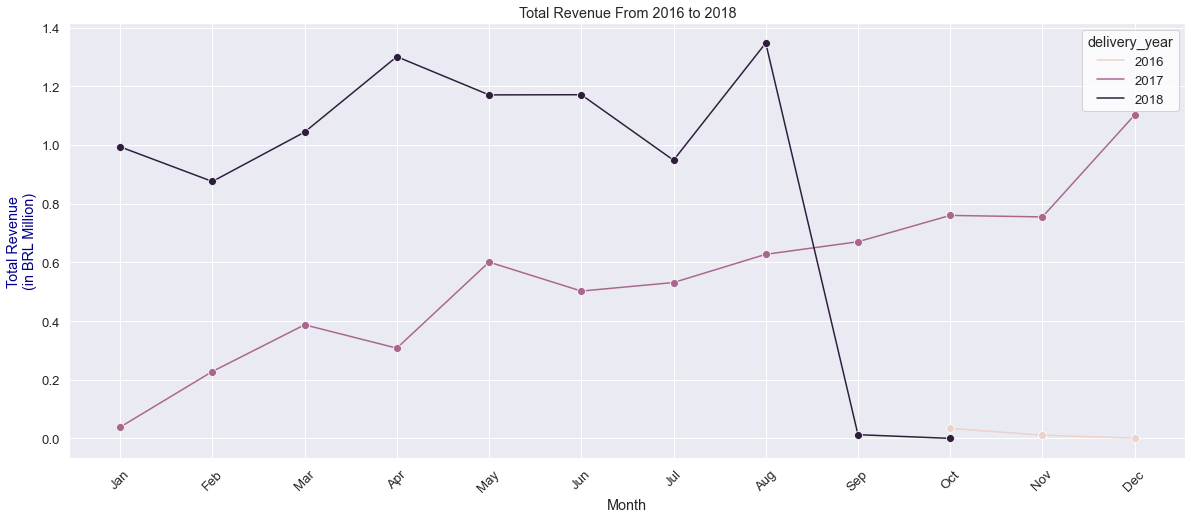

In [99]:
# total revenue split by month and year
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(20,8))
sns.set_style("whitegrid")
sns.lineplot(x=revenue_by_year_and_month['delivery_month'], y=revenue_by_year_and_month['payment_value'] / 1000000,hue=revenue_by_year_and_month['delivery_year'], marker='o', markersize=8)
plt.xticks(rotation=45)
ax.set_ylabel('Total Revenue\n(in BRL Million)', color='darkblue')
ax.yaxis.get_major_formatter().set_scientific(False)
ax.set_xlabel('Month')
ax.set_title('Total Revenue From 2016 to 2018')
plt.show(); # shows the plot.


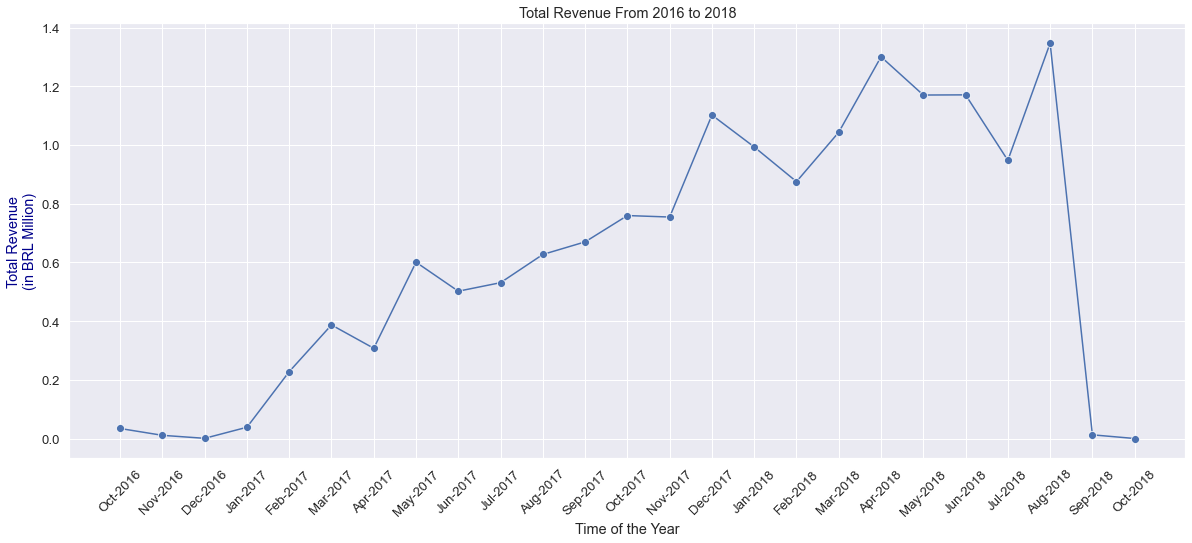

In [100]:
# Total revenue across all 3 years
revenue_by_year_and_month = revenue_by_year_and_month.sort_values(by=['delivery_year', 'delivery_month_no'])
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(20,8))
sns.set_style("dark")
sns.lineplot(x=revenue_by_year_and_month['delivery_month_year'], y=revenue_by_year_and_month['payment_value'] / 1000000, marker='o', markersize=8)
plt.xticks(rotation=45)
ax.set_ylabel('Total Revenue\n(in BRL Million)', color='darkblue')
ax.yaxis.get_major_formatter().set_scientific(False)
ax.set_xlabel('Time of the Year')
ax.set_title('Total Revenue From 2016 to 2018')
plt.show(); # shows the plot.


### 2. Which Brazilian states contribute to the highest / lowest revenue?<a class="anchor" id="q2"></a>
To answer this question, the revenue_table from q1. needs to be merged with the customer and geolocation dataframe. The customer and geolocation dataframe is first explored and cleaned. 

In [101]:
# check for duplicates in customer_id
custom[custom.duplicated(subset='customer_id')]

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state


In [102]:
# check for duplicates in customer_unique_id
len(custom[custom.duplicated(subset='customer_unique_id')])

3345

In [103]:
custom[custom.customer_unique_id == '66980c3775537536f77b434d74e520f5']


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
1139,9e29cde4ddb42f9330bcf3c9bc23d177,66980c3775537536f77b434d74e520f5,30290,belo horizonte,MG
2811,226d59f9f4b98e228b689eea45d03a6d,66980c3775537536f77b434d74e520f5,30290,belo horizonte,MG
81546,b2455d365185ab7c1da94e742e4976ad,66980c3775537536f77b434d74e520f5,30290,belo horizonte,MG


In [104]:
# check for duplicates in geolocation dataframe.
geolocation[geolocation.geolocation_zip_code_prefix.duplicated()].sort_values(by='geolocation_zip_code_prefix')

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
1435,1001,-23.549292,-46.633559,sao paulo,SP
639,1001,-23.550498,-46.634338,sao paulo,SP
583,1001,-23.551337,-46.634027,sao paulo,SP
575,1001,-23.549779,-46.633957,são paulo,SP
519,1001,-23.551337,-46.634027,sao paulo,SP
...,...,...,...,...,...
1000026,99980,-28.388679,-51.848863,david canabarro,RS
1000044,99980,-28.387691,-51.847330,david canabarro,RS
999764,99980,-28.386239,-51.847741,david canabarro,RS
999924,99980,-28.387693,-51.843881,david canabarro,RS


It seems that there are multiple duplicates of the geolocation_zip_code_prefix column where there are minimal differences in the geolocation_lat and geolocation_lng columns. To deal with this issue, duplicate rows are dropped and only the first row is kept. 

In [105]:
new_geolocation = geolocation.drop_duplicates(subset=['geolocation_zip_code_prefix'], keep='first').reset_index(drop='True')
new_geolocation

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1041,-23.544392,-46.639499,sao paulo,SP
3,1035,-23.541578,-46.641607,sao paulo,SP
4,1012,-23.547762,-46.635361,são paulo,SP
...,...,...,...,...,...
19010,99955,-28.107588,-52.144019,vila langaro,RS
19011,99970,-28.345143,-51.876926,ciriaco,RS
19012,99910,-27.863500,-52.084760,floriano peixoto,RS
19013,99920,-27.858716,-52.300403,erebango,RS


In [106]:
# a left merge is done as only rows from the revenue table are kept since the revenue table corresponds to orders that were delivered.
revenue_customer = revenue_table.merge(custom, on='customer_id', how='left')
revenue_customer = revenue_customer[['customer_unique_id', 'order_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state', 'payment_value']].sort_values(by='customer_unique_id')

In [107]:
# merge revenue_customer dataframe with new_geolocation dataframe to get the latitude and longitudes for a plot
revenue_customer_geolocation = revenue_customer.merge(new_geolocation, how='inner', left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix')
revenue_customer_geolocation = revenue_customer_geolocation[['customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state', 'payment_value']]

# calculate overall total revenue by state across 2016 to 2018
state_revenue_table = revenue_customer_geolocation.groupby('customer_state').sum()[['payment_value']].sort_values(by='payment_value', ascending=False).reset_index()
state_revenue_table.rename({'payment_value' : 'total_revenue', 'customer_state' : 'id'}, axis=1, inplace=True)
state_revenue_table['total_revenue_mil'] = (state_revenue_table['total_revenue'] / 1000000).round(2)


In [108]:
total_revenue = state_revenue_table.total_revenue_mil.sum()
print(f"The total revenue made from 2016 to 2018 is {round(total_revenue,2)} BRL Million")
state_revenue_table.head()

The total revenue made from 2016 to 2018 is 15.39 BRL Million


,id,total_revenue,total_revenue_mil
0,SP,5767062.53,5.77
1,RJ,2053660.01,2.05
2,MG,1818329.61,1.82
3,RS,861294.68,0.86
4,PR,781043.32,0.78


Note: plotly map of revenue by state below - this is not rendered as it takes up too much space.


In [109]:
# fig = px.choropleth_mapbox(state_revenue_table, geojson=brazil, locations='id', color='total_revenue_mil',
#                            color_continuous_scale="Viridis",
#                            range_color=(0, 12),
#                            mapbox_style="carto-positron",
#                            zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
#                            opacity=0.5,
#                            labels={'total_revenue_mil':'Total Revenue (BRL Million)'}
#                           )
# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
# fig.show()

### 3. Which Brazilian cities contribute to the highest / lowest revenue?<a class="anchor" id="q3"></a>
Using the same revenue_customer_geolocation dataframe from above, total revenue is calculated by groupign by city instead of state. 

In [110]:
# remove accents from city names
revenue_customer_geolocation['customer_city_new'] = revenue_customer_geolocation.apply(lambda x: unidecode(x['customer_city']), axis=1)

# calculate revenue by city
city_revenue = revenue_customer_geolocation.groupby('customer_city_new').sum()[['payment_value']].sort_values(by='payment_value', ascending=False).reset_index()
city_revenue.rename({'payment_value' : 'total_revenue'}, axis=1, inplace=True)
city_revenue['total_revenue_mil'] = (city_revenue['total_revenue'] / 1000000).round(2)
city_revenue

,customer_city_new,total_revenue,total_revenue_mil
0,sao paulo,2107798.43,2.11
1,rio de janeiro,1111872.32,1.11
2,belo horizonte,406050.87,0.41
3,brasilia,318000.10,0.32
4,curitiba,238582.26,0.24
...,...,...,...
4037,erico cardoso,24.88,0.00
4038,santo antonio do rio abaixo,24.23,0.00
4039,tamboara,24.09,0.00
4040,jenipapo de minas,22.58,0.00


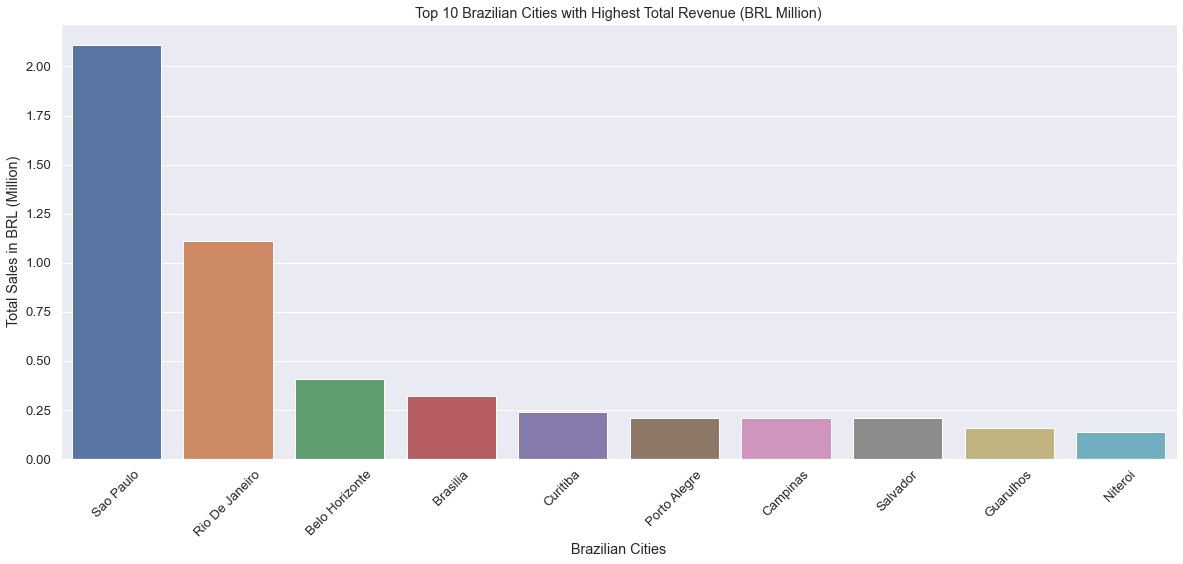

In [111]:
# Top 10 Brazilian Cities with Highest Sales in BRL Million
top_10_city_revenue = city_revenue.head(10)
bottom_10_city_revenue = city_revenue.tail(10)
top_10_city_revenue.customer_city_new = top_10_city_revenue.customer_city_new.str.title()
bottom_10_city_revenue.customer_city_new = bottom_10_city_revenue.customer_city_new.str.title()

sns.set(font_scale=1.2)
plt.figure(figsize=(20, 8))
fig = sns.barplot(data=top_10_city_revenue, x='customer_city_new', y='total_revenue_mil')
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.ticklabel_format(style='plain', axis='y')
fig.set_ylabel('Total Sales in BRL (Million)')
fig.set_xlabel('Brazilian Cities')
fig.set_title('Top 10 Brazilian Cities with Highest Total Revenue (BRL Million)')
plt.xticks(rotation=45)

plt.show()

### 4. How many orders were placed on Olist, and how does this vary by month or season?<a class="anchor" id="q4"></a>
To answer this question, the order statuses have to first be explored to find out what criteria to use to consider an order 'placed'. Following this step, the number of orders are calculated based on the order id. It is important to note, a single order can have duplicate rows as a single order can contain more than 1 product. 

In [112]:
orders.order_status.unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [113]:
# orders with statuses as unavaiable or cancelled are not considered as 'placed' orders.
placed_orders = orders[(orders['order_status'] == 'delivered')]

# check for null values
display(placed_orders.isnull().sum())

# orders with no approvals are also not considered as 'placed' orders
placed_orders = placed_orders[placed_orders.order_approved_at.notnull()]

order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_carrier_date      2
order_delivered_customer_date     8
order_estimated_delivery_date     0
dtype: int64

In [114]:
# total number of orders
total_placed_orders = len(placed_orders)

In [115]:
# the order purchase timestamp is indicative of when an order was placed.
placed_orders = extract_year_month(placed_orders, 'order_purchase_timestamp')

# order count by year
order_count_by_year = pd.DataFrame(placed_orders.groupby('delivery_year').count()['order_id']).reset_index()
order_count_by_year.rename({'order_id' : 'order_count'}, axis=1, inplace=True)

# order count by month
order_count_by_month = pd.DataFrame(placed_orders.groupby(['delivery_year', 'delivery_month_no', 'delivery_month']).count()['order_id']).reset_index()
order_count_by_month.rename({'order_id' : 'order_count'}, axis=1, inplace=True)

# order calculated by year and month
order_count_by_year_and_month = pd.DataFrame(placed_orders.groupby(['delivery_year', 'delivery_month', 'delivery_month_no'])['order_id'].count()).reset_index()
order_count_by_year_and_month['delivery_month_year'] = order_count_by_year_and_month['delivery_month'].map(str)+ '-' +order_count_by_year_and_month['delivery_year'].map(str)
order_count_by_year_and_month.rename({'order_id' : 'order_count'}, axis=1, inplace=True)
order_count_by_year_and_month = order_count_by_year_and_month.sort_values(by='delivery_month_no')

# order calculated by season
placed_orders['delivery_season'] = placed_orders['delivery_month_no'].apply(season)
order_count_by_season = pd.DataFrame(placed_orders.groupby('delivery_season')['order_id'].count()).reset_index()
order_count_by_season.rename({'order_id' : 'order_count'}, axis=1, inplace=True)

In [116]:
order_count_by_season

,delivery_season,order_count
0,autumn,28945
1,spring,16183
2,summer,21527
3,winter,29809


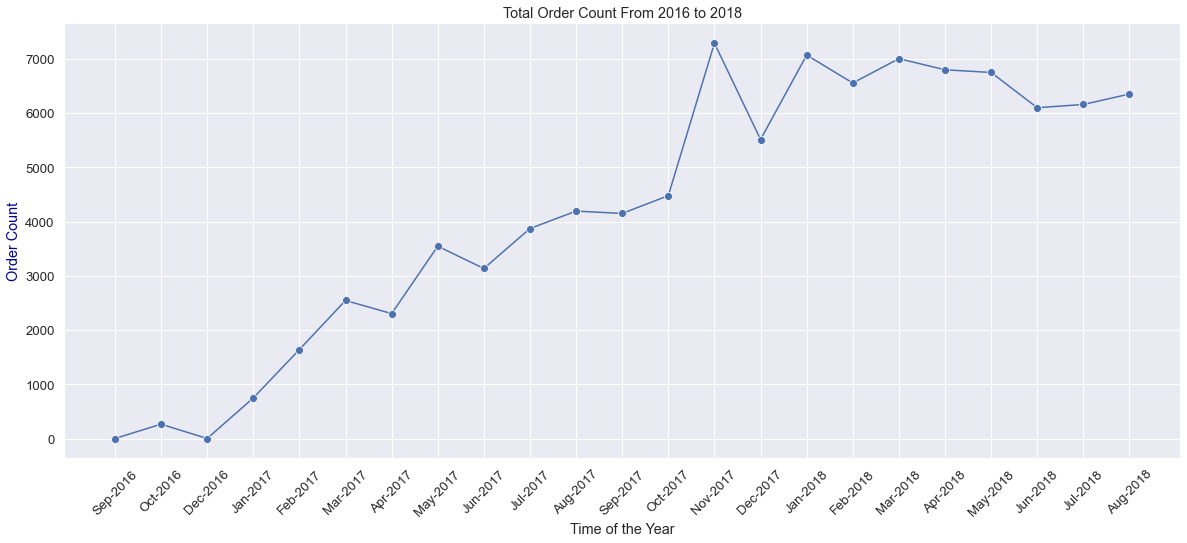

In [117]:
# Total revenue across all 3 years
order_count_by_year_and_month = order_count_by_year_and_month.sort_values(by=['delivery_year', 'delivery_month_no'])
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(20,8))
sns.set_style("dark")
sns.lineplot(x=order_count_by_year_and_month['delivery_month_year'], y=order_count_by_year_and_month['order_count'], marker='o', markersize=8)
plt.xticks(rotation=45)
ax.set_ylabel('Order Count', color='darkblue')
ax.yaxis.get_major_formatter().set_scientific(False)
ax.set_xlabel('Time of the Year')
ax.set_title('Total Order Count From 2016 to 2018')
plt.show(); # shows the plot.


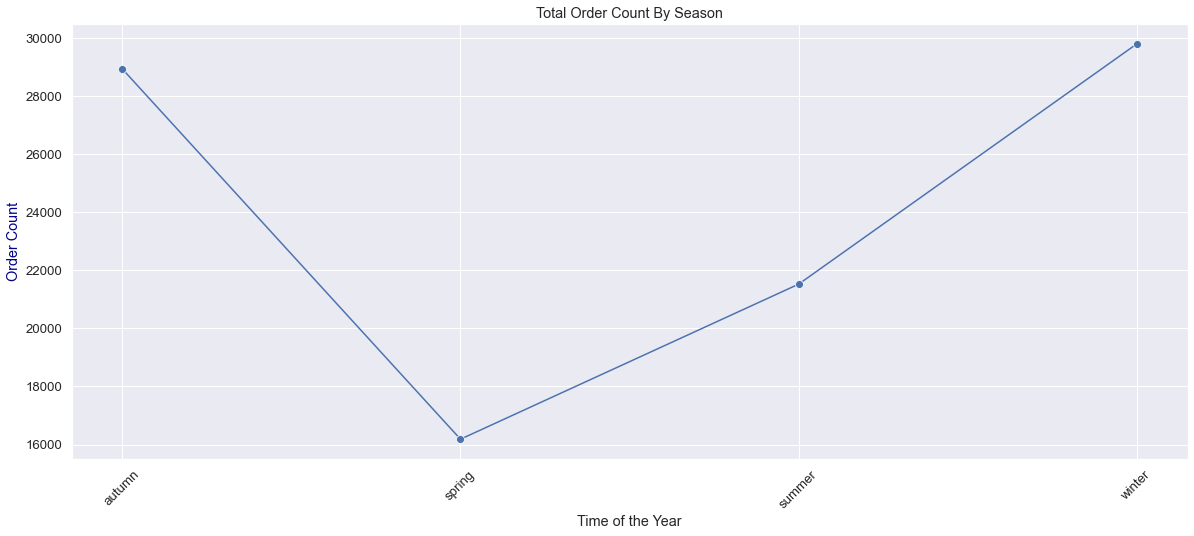

In [118]:
# Total revenue by season
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(20,8))
sns.set_style("dark")
sns.lineplot(x=order_count_by_season['delivery_season'], y=order_count_by_season['order_count'], marker='o', markersize=8, ci=None,palette='Set2')
plt.xticks(rotation=45)
ax.set_ylabel('Order Count', color='darkblue')
ax.yaxis.get_major_formatter().set_scientific(False)
ax.set_xlabel('Time of the Year')
ax.set_title('Total Order Count By Season')
plt.show(); # shows the plot.

### 5. What are the most popular product categories on Olist, and how do their sales volumes compare to each other?<a class="anchor" id="q5"></a>
The same placed orders dataframe as in the previous question is used here. Only delivered orders with no missing order_approved_at values are considered. To find out the product categories, the placed_orders dataframe is merged with order_items dataframe followed by merging with the products_df dataframe. 

In [119]:
new_orders_payments_items = new_orders_payments.merge(order_items, on='order_id', how='inner')
new_orders_payments_items = new_orders_payments_items[['order_id', 'order_status', 'order_delivered_customer_date', 'payment_value', 'payment_type', 'product_id', 'delivery_month_year', 'delivery_month_no', 'delivery_month', 'delivery_year']]

# check for missing values
new_orders_payments_items.isnull().sum()

# check for duplicate rows across all columns
new_orders_payments_items = new_orders_payments_items.drop_duplicates(keep='first')

# merge new_orders_payments_items with product_df
new_orders_payments_items_products = new_orders_payments_items.merge(products_df, on='product_id', how='left')
new_orders_payments_items_products = new_orders_payments_items_products[['product_category_name', 'order_id', 'order_status', 'order_delivered_customer_date', 'payment_type', 'payment_value', 'product_id', 'delivery_month_year', 'delivery_month_no', 'delivery_month', 'delivery_year']]

# check for duplicate rows
new_orders_payments_items_products[new_orders_payments_items_products.duplicated()]

# revenue by product category
revenue_by_product_category = new_orders_payments_items_products.groupby('product_category_name').sum('payment_value')['payment_value'].reset_index().sort_values(by='payment_value', ascending=False)
revenue_by_product_category.rename({'payment_value' : 'total_revenue'}, axis=1, inplace=True)

# order count by product category
order_count_by_product_category = new_orders_payments_items_products.groupby('product_category_name').count()['order_id'].reset_index().sort_values(by='order_id', ascending=False)
order_count_by_product_category.rename({'order_id' : 'order_count'}, axis=1, inplace=True)


In [120]:
# merge revenue by product with translations to get english translations.
revenue_by_product_category_translated = revenue_by_product_category.merge(translations_df, on='product_category_name', how='left')
revenue_by_product_category_translated['product_category_name_english'] = revenue_by_product_category_translated['product_category_name_english'].str.replace('_', '\n')

# check for rows with missing translations
revenue_by_product_category_translated[revenue_by_product_category_translated.product_category_name_english.isnull()]

# assign translations to rows with missing translations.
revenue_by_product_category_translated.loc[revenue_by_product_category_translated['product_category_name'] == 'portateis_cozinha_e_preparadores_de_alimentos', 'product_category_name_english'] = 'portable kitchen food preparers'
revenue_by_product_category_translated.loc[revenue_by_product_category_translated['product_category_name'] == 'pc_gamer', 'product_category_name_english'] = 'pc games'

revenue_by_product_category_translated = revenue_by_product_category_translated[['product_category_name_english', 'total_revenue']]
revenue_by_product_category_translated['total_revenue_mil'] = revenue_by_product_category_translated['total_revenue'] / 1000000

In [121]:
# merge revenue by product with translations to get english translations.
order_count_by_product_category_translated = order_count_by_product_category.merge(translations_df, on='product_category_name', how='left')
order_count_by_product_category_translated['product_category_name_english'] = order_count_by_product_category_translated['product_category_name_english'].str.replace('_', '\n')

# check for rows with missing translations
order_count_by_product_category_translated[order_count_by_product_category_translated.product_category_name_english.isnull()]

# assign translations to rows with missing translations.
order_count_by_product_category_translated.loc[order_count_by_product_category_translated['product_category_name'] == 'portateis_cozinha_e_preparadores_de_alimentos', 'product_category_name_english'] = 'portable kitchen food preparers'
order_count_by_product_category_translated.loc[order_count_by_product_category_translated['product_category_name'] == 'pc_gamer', 'product_category_name_english'] = 'pc games'

order_count_by_product_category_translated = order_count_by_product_category_translated[['product_category_name_english', 'order_count']]


Text(0.5, 1.0, 'Total Revenue of Top 10 Product Categories in BRL Million')

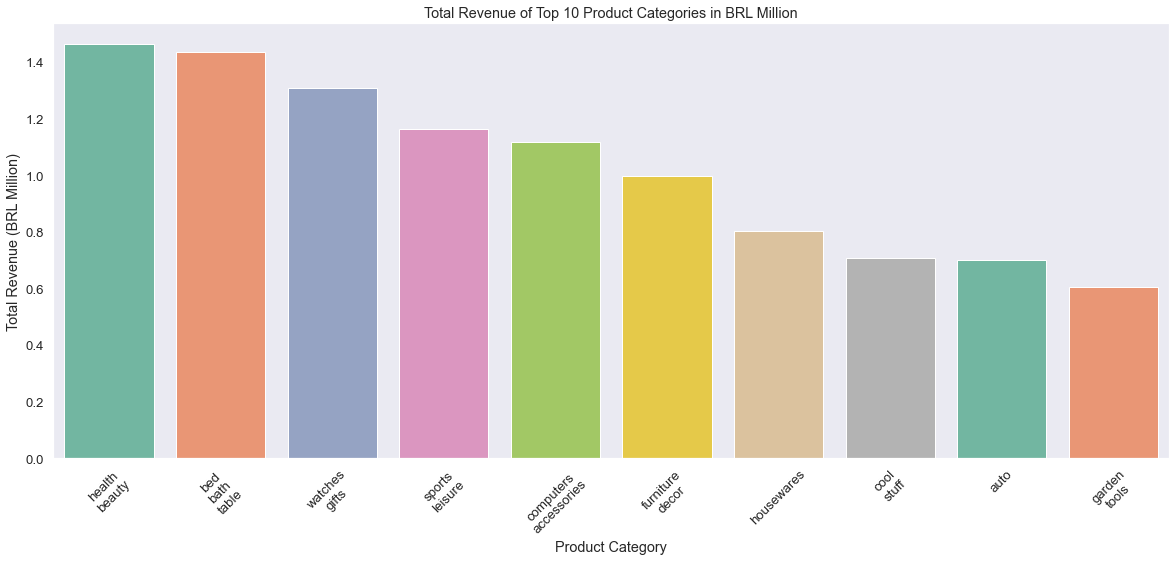

In [122]:
plt.figure(figsize=(20, 8))
fig = sns.barplot(data=revenue_by_product_category_translated.head(10), x='product_category_name_english', y='total_revenue_mil',palette='Set2')
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45)
fig.set_xlabel('Product Category')
fig.set_ylabel('Total Revenue (BRL Million)')
fig.set_title('Total Revenue of Top 10 Product Categories in BRL Million')


In [123]:
# merge order_count_by_product_category and revenue_by_product_category
total_revenue_order_count_product_category = order_count_by_product_category_translated.merge(revenue_by_product_category_translated, on='product_category_name_english', how='inner')
total_revenue_order_count_product_category.head()

,product_category_name_english,order_count,total_revenue,total_revenue_mil
0,bed\nbath\ntable,10568,1435791.24,1.435791
1,health\nbeauty,9054,1463137.61,1.463138
2,sports\nleisure,7902,1163519.65,1.163520
3,furniture\ndecor,6943,998647.23,0.998647
4,computers\naccessories,6941,1118989.20,1.118989


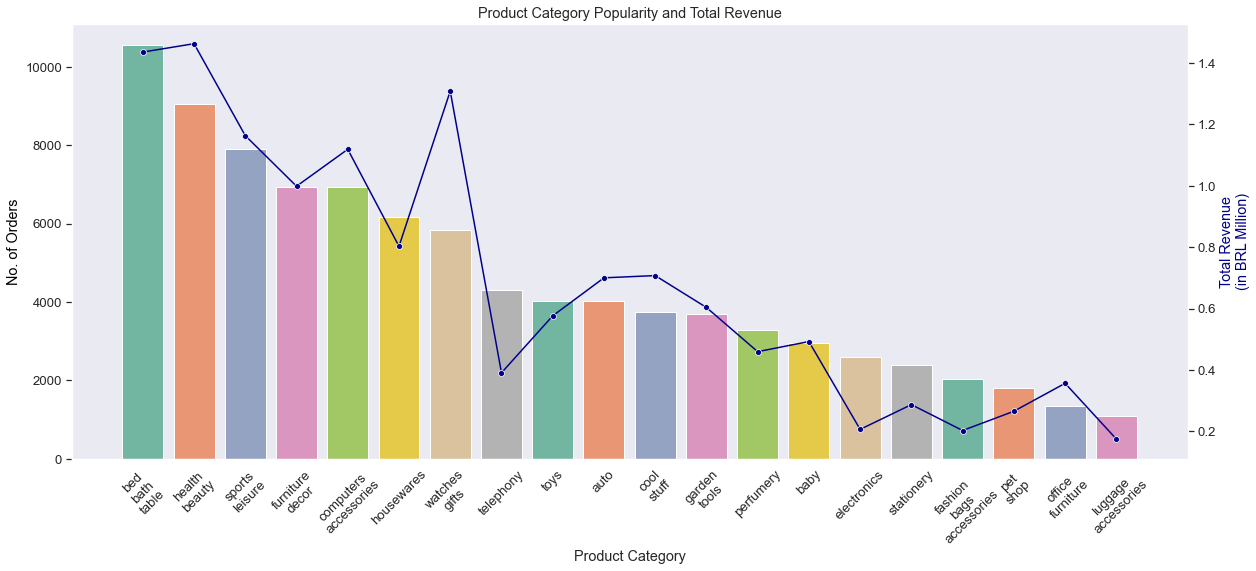

In [124]:
fig, ax1 = plt.subplots(figsize=(20, 8))
ax.grid()
plt.xticks(rotation = 45)
ax2 = ax1.twinx() # applies twinx to ax2, which is the second y axis.
top20_products = total_revenue_order_count_product_category.head(20)
plt.grid(False)

sns.set(font_scale=1.2)
sns.barplot(data=top20_products, x = 'product_category_name_english', y = 'order_count', ax = ax1, palette='Set2') # plots the first set of data, and sets it to ax1.
sns.lineplot(data=top20_products, x = 'product_category_name_english', y = 'total_revenue_mil', marker = 'o', color = 'darkblue', ax = ax2) # plots the second set, and sets to ax2.
plt.xticks(rotation=45)

# these lines add the annotations for the plot.
ax1.set_xlabel('Product Category')
ax1.set_ylabel('No. of Orders', color='black')
ax2.set_ylabel('Total Revenue\n(in BRL Million)', color='darkblue')
ax1.set_title('Product Category Popularity and Total Revenue')
ax2.yaxis.get_major_formatter().set_scientific(False)
plt.show(); # shows the plot.

### 6. What is the average order value (AOV) on Olist, and how does this vary by product category or payment method?<a class="anchor" id="q6"></a>
To calculate the average order value, the total revenue is divided by the total number of orders. To keep consistent with the assumptions, only orders that are delivered with no missing approved at dates are accounted for. 

In [125]:
average_order_value = total_revenue_order_count_product_category.total_revenue.sum() / total_revenue_order_count_product_category.order_count.sum()
print(f"The average order value is {round(average_order_value,2)} BRL")

The average order value is 157.67 BRL


Text(0.5, 1.0, 'Average Order Value of Top 10 Product Categories in BRL')

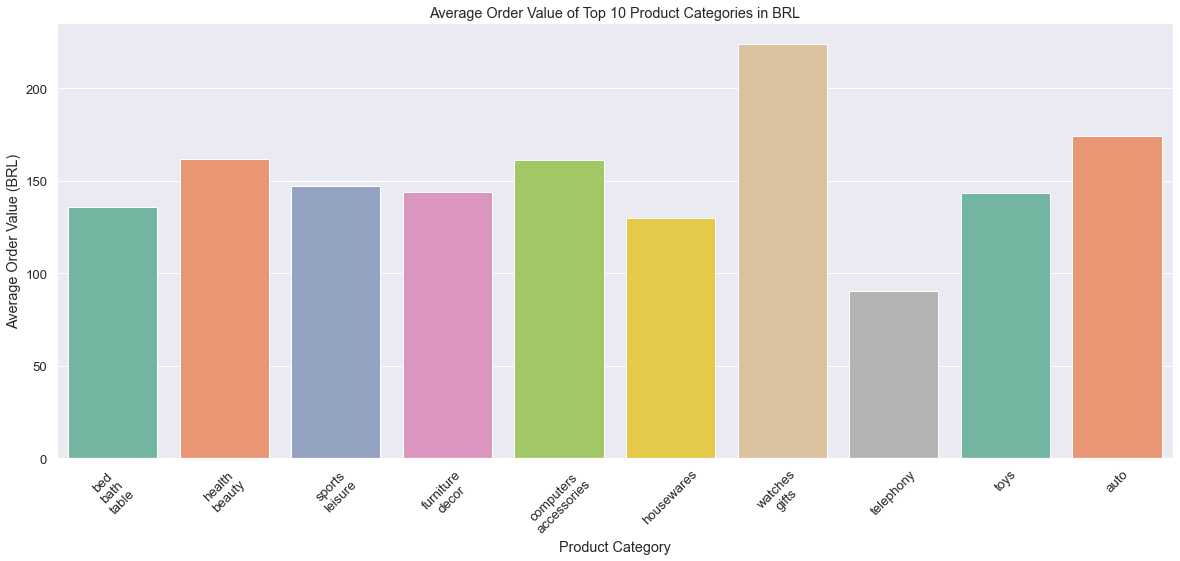

In [126]:
total_revenue_order_count_product_category['average_order_value'] = round(total_revenue_order_count_product_category['total_revenue'] / total_revenue_order_count_product_category['order_count'],2)

plt.figure(figsize=(20, 8))
fig = sns.barplot(data=total_revenue_order_count_product_category.head(10), x='product_category_name_english', y='average_order_value',palette='Set2')
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45)
fig.set_xlabel('Product Category')
fig.set_ylabel('Average Order Value (BRL)')
fig.set_title('Average Order Value of Top 10 Product Categories in BRL')


In [127]:
new_orders_payments_items_products = new_orders_payments_items_products[(new_orders_payments_items_products.order_status == 'delivered')]

# calculate total revenue and order count by category and payment type
revenue_by_category_payment_type = pd.DataFrame(new_orders_payments_items_products.groupby(['product_category_name', 'payment_type']).sum()['payment_value'])
ordercount_by_category_payment_type = pd.DataFrame(new_orders_payments_items_products.groupby(['product_category_name', 'payment_type']).count()['order_id'])

# merge revenue and order count
average_order_value_by_category = revenue_by_category_payment_type.merge(ordercount_by_category_payment_type, on=['product_category_name', 'payment_type'], how='left')
average_order_value_by_category.rename({'payment_value' : 'total_revenue', 'order_id' : 'order_count'}, axis=1, inplace=True)

# calculate average order value by category and payment type
average_order_value_by_category['average_order_value'] = average_order_value_by_category['total_revenue'] / average_order_value_by_category['order_count']
average_order_value_by_category.reset_index(inplace=True)

# merge with translations dataframe
average_order_value_by_category_translated = average_order_value_by_category.merge(translations_df, on='product_category_name', how='inner')
average_order_value_by_category_translated['product_category_name_english'] = average_order_value_by_category_translated['product_category_name_english'].str.replace('_', '\n')
average_order_value_by_category_translated = average_order_value_by_category_translated.sort_values(by=['product_category_name_english', 'payment_type', 'average_order_value'])


In [128]:
# get AOV basead on payment type and product_category
top10_average_order_value_by_category_translated = average_order_value_by_category_translated[average_order_value_by_category_translated.product_category_name_english.isin(total_revenue_order_count_product_category.head(10).product_category_name_english)]
aov_by_category = pd.DataFrame(top10_average_order_value_by_category_translated.groupby('product_category_name_english').sum()['average_order_value'])

# AOV in percent by payment_type
aov_by_payment_type = top10_average_order_value_by_category_translated.merge(aov_by_category, on='product_category_name_english', how='inner')
aov_by_payment_type['aov_percent'] = aov_by_payment_type['average_order_value_x'] / aov_by_payment_type['average_order_value_y'] * 100

aov_by_payment_type.head()

,product_category_name,payment_type,total_revenue,order_count,average_order_value_x,product_category_name_english,average_order_value_y,aov_percent
0,automotivo,boleto,114917.80,781,147.141869,auto,547.315723,26.884276
1,automotivo,credit_card,561421.90,3002,187.015956,auto,547.315723,34.169666
2,automotivo,debit_card,8443.34,69,122.367246,auto,547.315723,22.357707
3,automotivo,voucher,15343.62,169,90.790651,auto,547.315723,16.588351
4,cama_mesa_banho,boleto,214841.61,1685,127.502439,bed\nbath\ntable,476.781418,26.742326


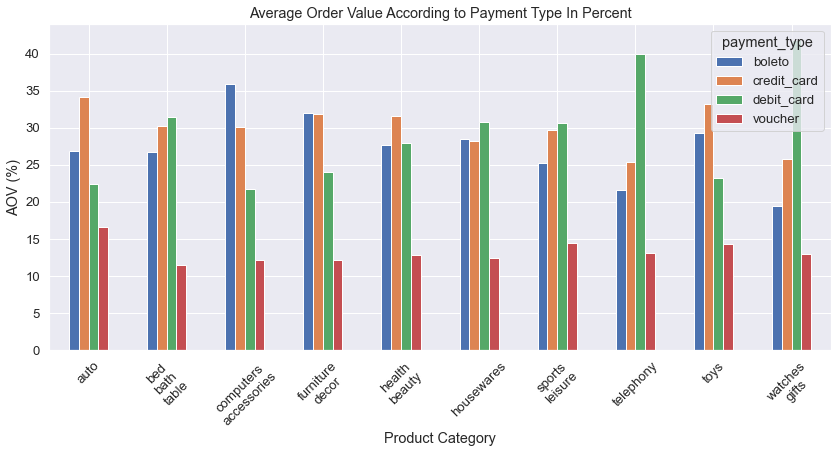

In [129]:
pivot_aov_by_payment_type = aov_by_payment_type.pivot_table('aov_percent', 'product_category_name_english', 'payment_type')
pivot_aov_by_payment_type
pivot_aov_by_payment_type.reset_index(inplace=True)

# AOV in percentage by product category and payment type
pivot_aov_by_payment_type.set_index('product_category_name_english').plot(kind='bar')
plt.gcf().set_size_inches(14,6)
plt.xlabel('Product Category')
plt.ylabel('AOV (%)')
plt.title('Average Order Value According to Payment Type In Percent')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45)
plt.show()
